### Summary
VAERS is the Vaccine Adverse Event Reporting System. This is a SELF reporting system for vaccine injury in the USA. The link below contains a portal where zip files can be downloaded of all adverse events recorded since the introduction of the system in 1990. 

https://vaers.hhs.gov/data/datasets.html

The files are CSV's and are joined using the code in this project. A few preliminary investigations and graphics are shown but the inten of this project is to serve as a starting place for others that want to perform there own analytics with the joined data. Have fun and let me know of any questions as I can be reached via email. 

In [2]:
# Imports 
import numpy as np
import pandas as pd
import pyodbc as db
import matplotlib.pyplot as plt
import os
%matplotlib inline
import requests
from requests.auth import HTTPBasicAuth
from io import StringIO
from sodapy import Socrata
from datetime import date
import datetime
import seaborn as sns
import configparser

# Constants 
stringVAERSDATA     = "VAERSDATA"
stringVAERSSYMPTOMS = "VAERSSYMPTOMS"
stringVAERSVAX      = "VAERSVAX"
inputDirectory      = '.\RAW_DATA'
reworkedInputs      = '.\REWORKED_DATA'
outputDirectory     = '.\OUTPUT'
pklInputDirectory   = '.\INPUT'

usePickle           = 0

# C:\Users\IDalrymple\AppData\Roaming\Python\Python37\Scripts
# C:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64

In [3]:
# API values - not being used be here in case we need more detailed MFG data 
# https://dev.socrata.com/foundry/data.cdc.gov/unsk-b7fc
# https://data.cdc.gov/Vaccinations/COVID-19-Vaccinations-in-the-United-States-Jurisdi/unsk-b7fc
# https://dev.socrata.com/foundry/data.cdc.gov/unsk-b7fc

# # Instantiate a config object
# oConfig = configparser.ConfigParser()

# # Read in the file 
# oConfig.read('VAERS_CONFIG.ini')

# # Now read in the values 
# apiKeyName      = oConfig["MFG_API"]["apiKeyName"]
# apiKeyId        = oConfig["MFG_API"]["apiKeyId"]
# apiSecretApi    = oConfig["MFG_API"]["apiSecretApi"]
# apiToken        = oConfig["MFG_API"]["apiToken"]
# apiSecretToken  = oConfig["MFG_API"]["apiSecretToken"]

In [4]:
# Return age bucket for age passed in 
def ageRangeFromAge(inAge):

    # Check ranges 
    if(inAge >= 100):
        return "GTE_100"
    elif(inAge >= 90):
        return "90_99"
    elif(inAge >= 80):
        return "80_89"
    elif(inAge >= 70):
        return "70_79"
    elif(inAge >= 60):
        return "60_69"
    elif(inAge >= 50):
        return "50_59"
    elif(inAge >= 40):
        return "40_49"
    elif(inAge >= 30):
        return "30_39"
    elif(inAge >= 20):
        return "20_29"
    elif(inAge >= 10):
        return "10_19"
    elif(inAge >= 0):
        return "0_9"
    else:
        return "UNKNOWN"

### Comments
This cell takes all the files and concatenates them together based on the key attribute ID. Note multiple entries can exist for the symptoms table for a single AE, hence the outer join. As s todo the data types need to be populated for each of the tables. 

In [5]:
# Locals 
dfVAERSDATA_Initialized     = False
dfVAERSSYMPTOMS_Initialized = False
dfVAERSVAX_Initialized      = False

# @TODO Column datatypes - need to finish  - getting the following warning when reading in files:
# DtypeWarning: Columns (11,13,15,16,27) have mixed types.Specify dtype option on import or set low_memory=False. interactivity=interactivity, compiler=compiler, result=result)
dtype_VAERSDATA = {"VAERS_ID": np.int64, "RECVDATE": np.object, "STATE": np.str, "AGE_YRS": np.float64, "CAGE_YR": np.float64, "CAGE_MO": np.float64, "SEX": np.str, "RPT_VDATE": np.object, "SYMPTOM_TEXT": np.str, "DIED": np.str, "DATEDIED": np.object, "L_THREAD": np.str, "ER_VISIT": np.str}

# Iterate over files 
for filename in os.listdir(inputDirectory):

    # Create the file name 
    fullFilename = os.path.join(inputDirectory, filename)

    # Ensure its a file
    if os.path.isfile(fullFilename):

        # Print the file name to see where it breaks - if needed 
        # print(fullFilename)

        # Overall
        if(fullFilename.__contains__(stringVAERSDATA)):
            
            # Check if the dataframe has been initialized
            if(dfVAERSDATA_Initialized == False):
                
                # Read in the file to this dataframe directly 
                dfVAERSDATA = pd.read_csv(fullFilename, encoding='cp1252', dtype=dtype_VAERSDATA)

                # Set to init 
                dfVAERSDATA_Initialized = True

            else:

                # Add the new file to the dataframe that has been init'd
                dfVAERSDATA = pd.concat([dfVAERSDATA, pd.read_csv(fullFilename, encoding='cp1252', dtype=dtype_VAERSDATA)], ignore_index=True)
            
        # Symptoms
        elif(fullFilename.__contains__(stringVAERSSYMPTOMS)):
            
            # Check if the dataframe has been initialized
            if(dfVAERSSYMPTOMS_Initialized == False):
                
                # Read in the file to this dataframe directly 
                dfVAERSSYMPTOMS = pd.read_csv(fullFilename, encoding='cp1252')

                # Set to init 
                dfVAERSSYMPTOMS_Initialized = True

            else:

                # Add the new file to the dataframe that has been init'd
                dfVAERSSYMPTOMS = pd.concat([dfVAERSSYMPTOMS, pd.read_csv(fullFilename, encoding='cp1252')], ignore_index=True)

        # Vax
        elif(fullFilename.__contains__(stringVAERSVAX)):
            
            # Check if the dataframe has been initialized
            if(dfVAERSVAX_Initialized == False):
                
                # Read in the file to this dataframe directly 
                dfVAERSVAX = pd.read_csv(fullFilename, encoding='cp1252')

                # Set to init 
                dfVAERSVAX_Initialized = True

            else:

                # Add the new file to the dataframe that has been init'd
                dfVAERSVAX = pd.concat([dfVAERSVAX, pd.read_csv(fullFilename, encoding='cp1252')], ignore_index=True)
        

# Merge the vax with the symptoms tables have duplicates or can 
# have duplicates hence using full outer join. Merging vax and symptoms first.
completeDataFrame = pd.merge(left = dfVAERSVAX, right = dfVAERSSYMPTOMS, \
                      how = "outer", left_on = ["VAERS_ID"], \
                      right_on = ["VAERS_ID"])

# Now merge the data frame into the merged frame 
completeDataFrame = pd.merge(left = completeDataFrame, right = dfVAERSDATA, \
                      how = "outer", left_on = ["VAERS_ID"], \
                      right_on = ["VAERS_ID"])

# Create a pickle 
completeDataFrame.to_pickle(os.path.join(outputDirectory, "completeDataFrame.pkl"))

# Performance notes:
# Takes about 100 seconds on Dell Precision 752 with Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, 2701 Mhz, 4 Core(s), 8 Logical Processor(s)

C:\Users\IanD\AppData\Local\Temp/ipykernel_17860/3260179011.py:8: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype_VAERSDATA = {"VAERS_ID": np.int64, "RECVDATE": np.object, "STATE": np.str, "AGE_YRS": np.float64, "CAGE_YR": np.float64, "CAGE_MO": np.float64, "SEX": np.str, "RPT_VDATE": np.object, "SYMPTOM_TEXT": np.str, "DIED": np.str, "DATEDIED": np.object, "L_THREAD": np.str, "ER_VISIT": np.str}
C:\Users\IanD\AppData\Local\Temp/ipykernel_17860/3260179011.py:8: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; 

In [6]:
if(usePickle == True):

    # Read in the pickle 
    completeDataFrame = pd.read_pickle(os.path.join(pklInputDirectory, "completeDataFrame.pkl"))

In [7]:
# Fill in the unknowns with negatives for age 
completeDataFrame["AGE_YRS"] = completeDataFrame["AGE_YRS"].fillna(-1)

# Fill in the unknowns with negatives for num days 
completeDataFrame["NUMDAYS"] = completeDataFrame["NUMDAYS"].fillna(completeDataFrame["NUMDAYS"].mode())

# Add a feature for age range 
completeDataFrame["AGE_RANGE"] = completeDataFrame["AGE_YRS"].apply(ageRangeFromAge)

# Make a copy so we can leave the original untouched 
workingVaxFrame = completeDataFrame.copy(deep=True)

### Comments
This cell uses a free socrata API to pull back the cumulative distribution and administered for each vaccine manufacturer for COVID-19 vax only. 

In [8]:
# Taken directly from 
# https://dev.socrata.com/foundry/data.cdc.gov/unsk-b7fc

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.cdc.gov", None)

# First 50000 results, returned as JSON from API / converted to Python list of dictionaries by sodapy.
getResults = client.get("unsk-b7fc", limit=50000)

# Convert to pandas DataFrame
administrationDataFrame = pd.DataFrame.from_records(getResults)

# Convert to date time 
administrationDataFrame["date"] = pd.to_datetime(administrationDataFrame["date"]).dt.date

# Make a copy so we can leave the original untouched 
workingAdministrationDataFrame = administrationDataFrame.copy(deep=True)

# Only return the latest date 
todaysAdministered = workingAdministrationDataFrame[workingAdministrationDataFrame.date == workingAdministrationDataFrame.date.max()]

# Print to file 
administrationDataFrame.to_csv(os.path.join(outputDirectory, "administrationDataFrame.csv"))

# Check data is present 
todaysAdministered.shape

# Example authenticated client (needed for non-public datasets):
# client = Socrata(data.cdc.gov,
#                  MyAppToken,
#                  userame="user@example.com",
#                  password="AFakePassword")

# Alternative method - may be useful later 
# rawResponse = requests.get('https://data.cdc.gov/resource/unsk-b7fc.csv', auth=HTTPBasicAuth(apiKeyId, apiSecretApi))
# stringResponse = StringIO(rawResponse.text)
# vaxAdministeredDataFrame = pd.read_csv(stringResponse, sep =",")
# vaxAdministeredDataFrame.to_csv("vaxAdministeredDataFrame.csv")

(64, 82)

### Comments 
Finally we can calculate the total deaths per manufacturer as well as the total deaths as of the date of this post. These stats are for the COVID vax only.

TOTAL DEATHS: 24827


<AxesSubplot:title={'center':'Total Death Count vs. Manufacturer'}>

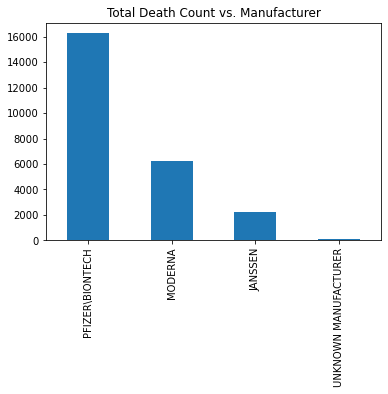

In [9]:
# Get all the values of the type of vaccine to try and find the covid 
covidFrame = workingVaxFrame[workingVaxFrame["VAX_TYPE"] == "COVID19"]

# Get all the deaths per manufacturer
covidDeathsFramePerMfg = (covidFrame[covidFrame["DIED"] == "Y"].drop_duplicates(subset=["VAERS_ID"]))["VAX_MANU"].value_counts().to_frame()

# Convert to a float 
covidDeathsFramePerMfg["VAX_MANU"] = covidDeathsFramePerMfg["VAX_MANU"].astype("float")

# Show the total events 
print("TOTAL DEATHS:", covidDeathsFramePerMfg["VAX_MANU"].sum().astype("int"))

# Show graphs of deaths per million for each mfg 
covidDeathsFramePerMfg["VAX_MANU"].plot(kind = "bar", title = "Total Death Count vs. Manufacturer")

<AxesSubplot:title={'center':'Deaths per Million vs. Manufacturer'}>

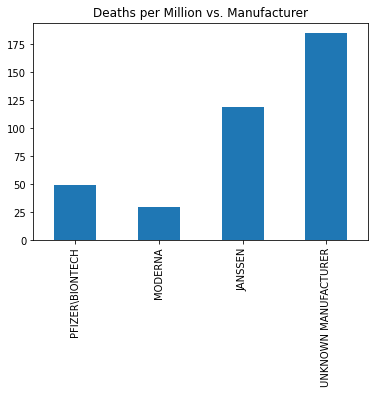

In [10]:
# Get todays date for us only 
usAdministered = todaysAdministered[todaysAdministered.location == "US"]

# Make a copy of the deaths frame 
localCovidDeathsFramePerMfg = covidDeathsFramePerMfg.copy(deep = True)

# Percent deaths 
localCovidDeathsFramePerMfg.loc["PFIZER\BIONTECH"].VAX_MANU          = (float)((float)(localCovidDeathsFramePerMfg.loc["PFIZER\BIONTECH"].VAX_MANU) / (float)(usAdministered["administered_pfizer"])) * 1000000.0
localCovidDeathsFramePerMfg.loc["MODERNA"].VAX_MANU                  = (float)((float)(localCovidDeathsFramePerMfg.loc["MODERNA"].VAX_MANU) / (float)(usAdministered["administered_moderna"])) * 1000000.0
localCovidDeathsFramePerMfg.loc["JANSSEN"].VAX_MANU                  = (float)((float)(localCovidDeathsFramePerMfg.loc["JANSSEN"].VAX_MANU) / (float)(usAdministered["administered_janssen"])) * 1000000.0
localCovidDeathsFramePerMfg.loc["UNKNOWN MANUFACTURER"].VAX_MANU     = (float)((float)(localCovidDeathsFramePerMfg.loc["UNKNOWN MANUFACTURER"].VAX_MANU) / (float)(usAdministered["administered_unk_manuf"])) * 1000000.0

# Show graphs of deaths per million for each mfg 
localCovidDeathsFramePerMfg["VAX_MANU"].plot(kind = "bar", title = "Deaths per Million vs. Manufacturer")

TOTAL EVENTS: 1151450


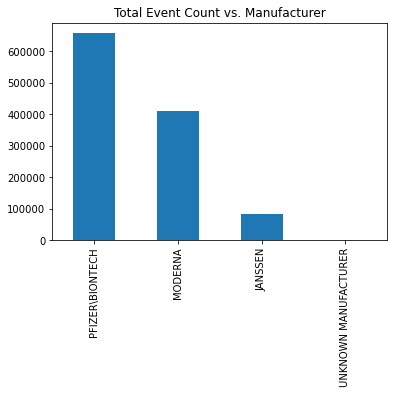

In [11]:
# Get all the events per manufacturer
covidEventsFramePerMfg = (covidFrame.drop_duplicates(subset=["VAERS_ID"]))["VAX_MANU"].value_counts().to_frame()

# Convert to a float 
covidEventsFramePerMfg["VAX_MANU"] = covidEventsFramePerMfg["VAX_MANU"].astype("float")

# Show graphs of deaths per million for each mfg 
covidEventsFramePerMfg["VAX_MANU"].plot(kind = "bar", title = "Total Event Count vs. Manufacturer")

# Show the total events 
print("TOTAL EVENTS:", covidEventsFramePerMfg["VAX_MANU"].sum().astype("int"))

<AxesSubplot:title={'center':'Events per Million vs. Manufacturer'}>

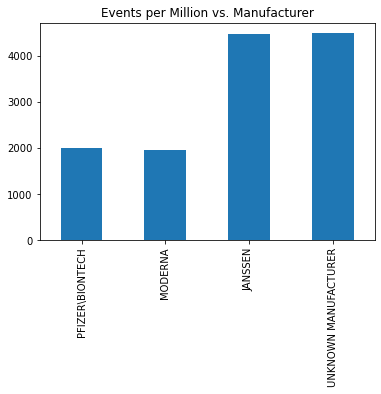

In [12]:
# Make a copy of the deaths frame 
localCovidEventsFramePerMfg = covidEventsFramePerMfg.copy(deep = True)

# Percent deaths 
localCovidEventsFramePerMfg.loc["PFIZER\BIONTECH"].VAX_MANU          = (float)((float)(localCovidEventsFramePerMfg.loc["PFIZER\BIONTECH"].VAX_MANU) / (float)(usAdministered["administered_pfizer"])) * 1000000.0
localCovidEventsFramePerMfg.loc["MODERNA"].VAX_MANU                  = (float)((float)(localCovidEventsFramePerMfg.loc["MODERNA"].VAX_MANU) / (float)(usAdministered["administered_moderna"])) * 1000000.0
localCovidEventsFramePerMfg.loc["JANSSEN"].VAX_MANU                  = (float)((float)(localCovidEventsFramePerMfg.loc["JANSSEN"].VAX_MANU) / (float)(usAdministered["administered_janssen"])) * 1000000.0
localCovidEventsFramePerMfg.loc["UNKNOWN MANUFACTURER"].VAX_MANU     = (float)((float)(localCovidEventsFramePerMfg.loc["UNKNOWN MANUFACTURER"].VAX_MANU) / (float)(usAdministered["administered_unk_manuf"])) * 1000000.0

# Show graphs of deaths per million for each mfg 
localCovidEventsFramePerMfg["VAX_MANU"].plot(kind = "bar", title = "Events per Million vs. Manufacturer")

<AxesSubplot:title={'center':'Deaths per Million vs. Manufacturer / Age Group'}, xlabel='AGE_RANGE'>

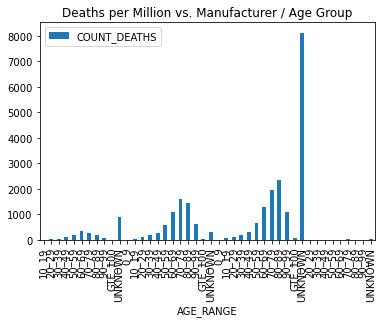

In [13]:
# Get just the deaths removing dupes
covidDeathsFramePerMfgAndAge = (covidFrame[covidFrame["DIED"] == "Y"].drop_duplicates(subset=["VAERS_ID"]))

# Now group by the age and manufacturer 
covidDeathsFramePerMfgAndAge = covidDeathsFramePerMfgAndAge.groupby(['VAX_MANU','AGE_RANGE'])["VAERS_ID"].count().reset_index()

# Rename the agg column 
covidDeathsFramePerMfgAndAge.rename(columns = {'VAERS_ID':'COUNT_DEATHS'}, inplace = True)

# Create indices out of the two id columns 
#covidDeathsFramePerMfgAndAge = covidDeathsFramePerMfgAndAge.set_index(['VAX_MANU','AGE_RANGE'])
covidDeathsFramePerMfgAndAge = covidDeathsFramePerMfgAndAge.set_index(['AGE_RANGE'])

# Show graphs of deaths per million for each mfg 
covidDeathsFramePerMfgAndAge.plot(kind = "bar", title = "Deaths per Million vs. Manufacturer / Age Group")

In [14]:
# Get all the values of the type of vaccine to try and find the covid 
covidDeathsFrame = workingVaxFrame[workingVaxFrame["VAX_TYPE"] == "COVID19"]

# Get all the deaths
covidDeathsFrame = covidFrame[covidFrame["DIED"] == "Y"].drop_duplicates(subset=["VAERS_ID"])

# Now group by the age and manufacturer 
covidDeathsFramePerMfgAndLot = covidDeathsFrame.groupby(['VAX_MANU','VAX_LOT'])["VAERS_ID"].count().reset_index()

# Print the results 
covidDeathsFramePerMfgAndLot.to_csv(os.path.join(outputDirectory, "LOTS.csv"))

<AxesSubplot:title={'center':'Symptom One Count'}, xlabel='SYMPTOM'>

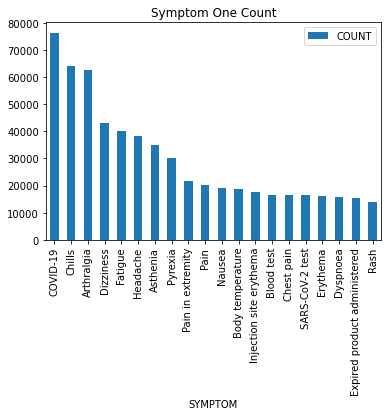

In [15]:
# NOTE: take a look at symptoms

# Just get the covid vaccines 
covidSymptomsOne = workingVaxFrame[workingVaxFrame["VAX_TYPE"] == "COVID19"]

# Now look at the symptoms 
covidSymptomsOne = covidSymptomsOne.groupby("SYMPTOM1")["SYMPTOM1"].count().to_frame()

# Rename the columns 
covidSymptomsOne.columns = ["SYMPTOM"]

# Reset the index 
covidSymptomsOne = covidSymptomsOne.reset_index()

# Rename again 
covidSymptomsOne.columns = ["SYMPTOM", "COUNT"]

# Show the results 
covidSymptomsOne.sort_values(by="COUNT", ascending=False).head(20).plot(x="SYMPTOM", y="COUNT", kind = "bar", title = "Symptom One Count")

<AxesSubplot:title={'center':'Symptom Two Count'}, xlabel='SYMPTOM'>

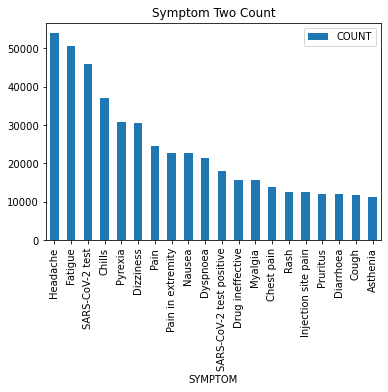

In [16]:
# NOTE: take a look at symptoms

# Just get the covid vaccines 
covidSymptomsTwo = workingVaxFrame[workingVaxFrame["VAX_TYPE"] == "COVID19"]

# Now look at the symptoms 
covidSymptomsTwo = covidSymptomsTwo.groupby("SYMPTOM2")["SYMPTOM2"].count().to_frame()

# Rename the columns 
covidSymptomsTwo.columns = ["SYMPTOM"]

# Reset the index 
covidSymptomsTwo = covidSymptomsTwo.reset_index()

# Rename again 
covidSymptomsTwo.columns = ["SYMPTOM", "COUNT"]

# Show the results 
covidSymptomsTwo.sort_values(by="COUNT", ascending=False).head(20).plot(x="SYMPTOM", y="COUNT", kind = "bar", title = "Symptom Two Count")

<AxesSubplot:title={'center':'Symptom Three Count'}, xlabel='SYMPTOM'>

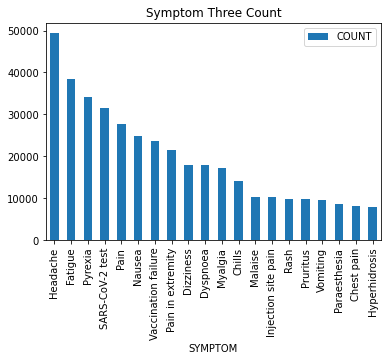

In [17]:
# NOTE: take a look at symptoms

# Just get the covid vaccines 
covidSymptomsThree = workingVaxFrame[workingVaxFrame["VAX_TYPE"] == "COVID19"]

# Now look at the symptoms 
covidSymptomsThree = covidSymptomsThree.groupby("SYMPTOM3")["SYMPTOM3"].count().to_frame()

# Rename the columns 
covidSymptomsThree.columns = ["SYMPTOM"]

# Reset the index 
covidSymptomsThree = covidSymptomsThree.reset_index()

# Rename again 
covidSymptomsThree.columns = ["SYMPTOM", "COUNT"]

# Show the results 
covidSymptomsThree.sort_values(by="COUNT", ascending=False).head(20).plot(x="SYMPTOM", y="COUNT", kind = "bar", title = "Symptom Three Count")

<AxesSubplot:title={'center':'Symptom Four Count'}, xlabel='SYMPTOM'>

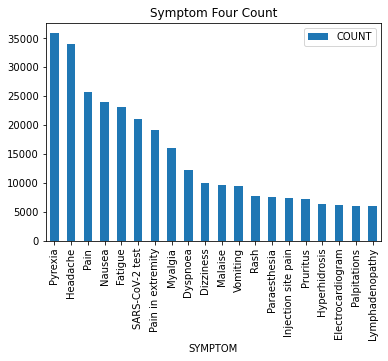

In [18]:
# NOTE: take a look at symptoms

# Just get the covid vaccines 
covidSymptomsFour = workingVaxFrame[workingVaxFrame["VAX_TYPE"] == "COVID19"]

# Now look at the symptoms 
covidSymptomsFour = covidSymptomsFour.groupby("SYMPTOM4")["SYMPTOM4"].count().to_frame()

# Rename the columns 
covidSymptomsFour.columns = ["SYMPTOM"]

# Reset the index 
covidSymptomsFour = covidSymptomsFour.reset_index()

# Rename again 
covidSymptomsFour.columns = ["SYMPTOM", "COUNT"]

# Show the results 
covidSymptomsFour.sort_values(by="COUNT", ascending=False).head(20).plot(x="SYMPTOM", y="COUNT", kind = "bar", title = "Symptom Four Count")

<AxesSubplot:title={'center':'Symptom Five Count'}, xlabel='SYMPTOM'>

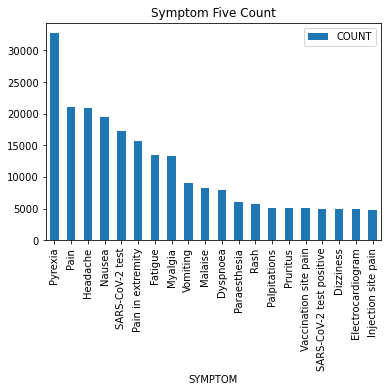

In [19]:
# NOTE: take a look at symptoms

# Just get the covid vaccines 
covidSymptomsFive = workingVaxFrame[workingVaxFrame["VAX_TYPE"] == "COVID19"]

# Now look at the symptoms 
covidSymptomsFive = covidSymptomsFive.groupby("SYMPTOM5")["SYMPTOM5"].count().to_frame()

# Rename the columns 
covidSymptomsFive.columns = ["SYMPTOM"]

# Reset the index 
covidSymptomsFive = covidSymptomsFive.reset_index()

# Rename again 
covidSymptomsFive.columns = ["SYMPTOM", "COUNT"]

# Show the results 
covidSymptomsFive.sort_values(by="COUNT", ascending=False).head(20).plot(x="SYMPTOM", y="COUNT", kind = "bar", title = "Symptom Five Count")

<AxesSubplot:title={'center':'Combined Symptom Count'}, xlabel='SYMPTOM'>

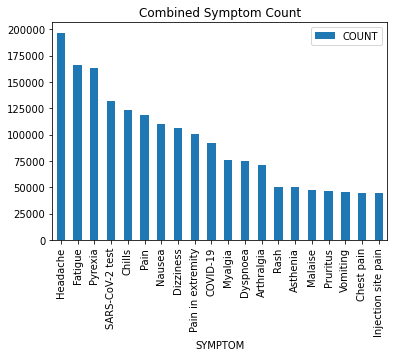

In [20]:
# Combine them again
combinedSymptoms = pd.concat([covidSymptomsOne, covidSymptomsTwo, covidSymptomsThree, covidSymptomsFour, covidSymptomsFive], ignore_index=True)

# Lets recount since there may be duplicates 
combinedSymptoms = combinedSymptoms.groupby("SYMPTOM")["COUNT"].sum().to_frame().reset_index()

# Show the results 
combinedSymptoms.sort_values(by="COUNT", ascending=False).head(20).plot(x="SYMPTOM", y="COUNT", kind = "bar", title = "Combined Symptom Count")

<AxesSubplot:title={'center':'Combined ITIS Symptom Count'}, xlabel='SYMPTOM'>

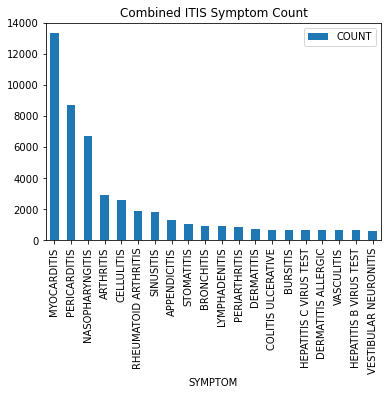

In [21]:
# Make a copy 
itisFrame = combinedSymptoms.copy(deep=True)

# First make the symptoms caps
itisFrame["SYMPTOM"] = itisFrame['SYMPTOM'].apply(lambda SYMPTOM : SYMPTOM.upper()).to_frame()

# Look for inflammation symptoms 
itisFrame = itisFrame[itisFrame["SYMPTOM"].str.contains("ITIS")]

# Show the top hitters 
itisFrame.sort_values(by="COUNT", ascending=False).head(20).plot(x="SYMPTOM", y="COUNT", kind = "bar", title = "Combined ITIS Symptom Count")

In [22]:
# Total number of myo and pericarditis 
totalMyoAndPer = itisFrame[itisFrame["SYMPTOM"] == "MYOCARDITIS"]["COUNT"].sum() + itisFrame[itisFrame["SYMPTOM"] == "PERICARDITIS"]["COUNT"].sum()

# Show the result 
print("Total myocarditis and pericarditis is", totalMyoAndPer)

Total myocarditis and pericarditis is 22043


<AxesSubplot:title={'center':'Combined Cancer Symptom Count'}, xlabel='SYMPTOM'>

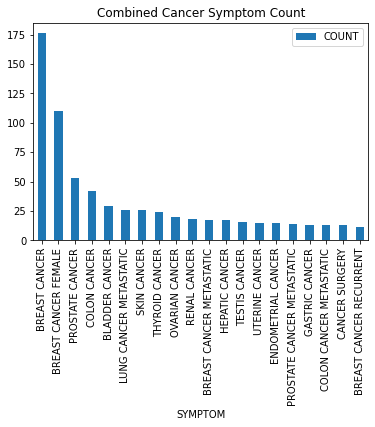

In [23]:
# Make a copy 
cancerFrame = combinedSymptoms.copy(deep=True)

# First make the symptoms caps
cancerFrame["SYMPTOM"] = cancerFrame['SYMPTOM'].apply(lambda SYMPTOM : SYMPTOM.upper()).to_frame()

# Look for inflammation symptoms 
cancerFrame = cancerFrame[cancerFrame["SYMPTOM"].str.contains("CANCER")]

# Show the top hitters 
cancerFrame.sort_values(by="COUNT", ascending=False).head(20).plot(x="SYMPTOM", y="COUNT", kind = "bar", title = "Combined Cancer Symptom Count")

<AxesSubplot:title={'center':'Combined Herpes Symptom Count'}, xlabel='SYMPTOM'>

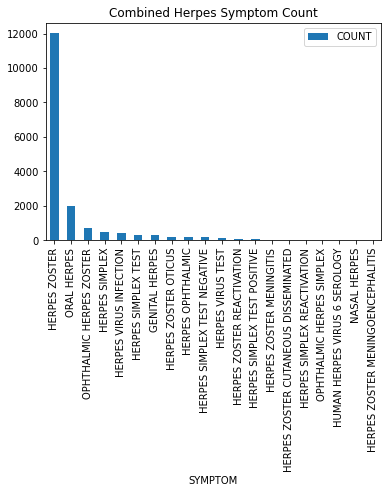

In [24]:
# Make a copy 
herpesFrame = combinedSymptoms.copy(deep=True)

# First make the symptoms caps
herpesFrame["SYMPTOM"] = herpesFrame['SYMPTOM'].apply(lambda SYMPTOM : SYMPTOM.upper()).to_frame()

# Look for inflammation symptoms 
herpesFrame = herpesFrame[herpesFrame["SYMPTOM"].str.contains("HERPES")]

# Show the top hitters 
herpesFrame.sort_values(by="COUNT", ascending=False).head(20).plot(x="SYMPTOM", y="COUNT", kind = "bar", title = "Combined Herpes Symptom Count")

In [25]:
# Simple method to check for death related words in a string 
def checkForDeath(inText):

    # Make sure the text passed in is capitalized 
    upperText = inText.upper()

    # Key words 
    keyWords = ["DEATH", "DEAD", "DIED", "DIE", "CASUALITY"]

    # Check if present 
    if(any(x in upperText for x in keyWords)):
        return 1
    else:
        return 0

# Make a copy 
deathSymptomFrame = combinedSymptoms.copy(deep=True)

# First make the symptoms caps
deathSymptomFrame["SYMPTOM"] = deathSymptomFrame['SYMPTOM'].apply(lambda SYMPTOM : SYMPTOM.upper()).to_frame()

# Look for inflammation symptoms 
# deathSymptomFrame = deathSymptomFrame[deathSymptomFrame["SYMPTOM"].str.contains("DEATH")]
deathSymptomFrame["CONTAIN_DEAD"] = deathSymptomFrame["SYMPTOM"].apply(lambda symptomText: checkForDeath(symptomText))

deathSymptomFrame.CONTAIN_DEAD.sum()

# Show the top hitters 
# herpesFrame.sort_values(by="COUNT", ascending=False).head(20).plot(x="SYMPTOM", y="COUNT", kind = "bar", title = "Combined Herpes Symptom Count")

53

In [26]:
# NOTE: take a look at the deaths based on the dose in the series 

# Get all the values of the type of vaccine to try and find the covid 
covidFrame = workingVaxFrame[workingVaxFrame["VAX_TYPE"] == "COVID19"]

# Get all the deaths per manufacturer
covidFrame = covidFrame[covidFrame["DIED"] == "Y"].drop_duplicates(subset=["VAERS_ID"])

# Look at deaths per vax dose 
covidFrame.groupby("VAX_DOSE_SERIES")["VAX_DOSE_SERIES"].count()

VAX_DOSE_SERIES
1      9842
2      7455
3      1556
4         3
5         4
6         1
7+        7
UNK    5937
Name: VAX_DOSE_SERIES, dtype: int64

In [27]:
# Locals 
dfVAERSDATA_Initialized     = False
dfVAERSSYMPTOMS_Initialized = False
dfVAERSVAX_Initialized      = False

# @TODO Column datatypes - need to finish  - getting the following warning when reading in files:
# DtypeWarning: Columns (11,13,15,16,27) have mixed types.Specify dtype option on import or set low_memory=False. interactivity=interactivity, compiler=compiler, result=result)
dtype_VAERSDATA = {"VAERS_ID": np.int64, "RECVDATE": np.object, "STATE": np.str, "AGE_YRS": np.float64, "CAGE_YR": np.float64, "CAGE_MO": np.float64, "SEX": np.str, "RPT_VDATE": np.object, "SYMPTOM_TEXT": np.str, "DIED": np.str, "DATEDIED": np.object, "L_THREAD": np.str, "ER_VISIT": np.str}

# Iterate over files 
for filename in os.listdir(inputDirectory):

    # Create the file name 
    fullFilename = os.path.join(inputDirectory, filename)

    # Ensure its a file
    if os.path.isfile(fullFilename):

        # Print the file name to see where it breaks - if needed 
        # print(fullFilename)

        # Overall
        if(fullFilename.__contains__(stringVAERSDATA)):
            
            # Check if the dataframe has been initialized
            if(dfVAERSDATA_Initialized == False):
                
                # Read in the file to this dataframe directly 
                dfVAERSDATA = pd.read_csv(fullFilename, encoding='cp1252', dtype=dtype_VAERSDATA)

                # Set to init 
                dfVAERSDATA_Initialized = True

            else:

                # Add the new file to the dataframe that has been init'd
                dfVAERSDATA = pd.concat([dfVAERSDATA, pd.read_csv(fullFilename, encoding='cp1252', dtype=dtype_VAERSDATA)], ignore_index=True)


        # Vax
        elif(fullFilename.__contains__(stringVAERSVAX)):
            
            # Check if the dataframe has been initialized
            if(dfVAERSVAX_Initialized == False):
                
                # Read in the file to this dataframe directly 
                dfVAERSVAX = pd.read_csv(fullFilename, encoding='cp1252')

                # Set to init 
                dfVAERSVAX_Initialized = True

            else:

                # Add the new file to the dataframe that has been init'd
                dfVAERSVAX = pd.concat([dfVAERSVAX, pd.read_csv(fullFilename, encoding='cp1252')], ignore_index=True)

# Merge the vax with the symptoms tables have duplicates or can 
# have duplicates hence using full outer join. Merging vax and symptoms first.
lotFrame = pd.merge(left = dfVAERSVAX, right = dfVAERSDATA, \
                      how = "outer", left_on = ["VAERS_ID"], \
                      right_on = ["VAERS_ID"])

# Create a pickle 
lotFrame.to_pickle(os.path.join(outputDirectory, "lotFrame.pkl"))

# Performance notes:
# Takes about 100 seconds on Dell Precision 752 with Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, 2701 Mhz, 4 Core(s), 8 Logical Processor(s)

C:\Users\IanD\AppData\Local\Temp/ipykernel_17860/3496206653.py:8: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype_VAERSDATA = {"VAERS_ID": np.int64, "RECVDATE": np.object, "STATE": np.str, "AGE_YRS": np.float64, "CAGE_YR": np.float64, "CAGE_MO": np.float64, "SEX": np.str, "RPT_VDATE": np.object, "SYMPTOM_TEXT": np.str, "DIED": np.str, "DATEDIED": np.object, "L_THREAD": np.str, "ER_VISIT": np.str}
C:\Users\IanD\AppData\Local\Temp/ipykernel_17860/3496206653.py:8: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; 

In [28]:
def intTryParse(value):
    try:
        return int(value), True
    except ValueError:
        return value, False

def filterLotCodes(inLot):

    # NOTE: order matters here so consider before modifying.

    # Strings to drop for 
    stringToDropFor = ["UNK", "UNKNOWN", "NOR KNOWN", "NOR KNOWN", "NOT AVAILABLE", "DON?T HAVE"]
    
    # First convert to string and capitalize and trim off leading and trailing spaces 
    localLot = str(inLot)
    localLot = localLot.strip()
    localLot = localLot.upper()

    # Now strip out Pfizer and moderna
    localLot = str(localLot.replace("PFIZER", ""))
    localLot = str(localLot.replace("MODERNA", ""))
    localLot = str(localLot.replace("MODERNS", ""))
    localLot = str(localLot.replace("MODERN A", ""))
    localLot = str(localLot.replace("MODERN", ""))
    localLot = str(localLot.replace("MRNA", ""))
    localLot = str(localLot.replace("BIONTECH", ""))
    localLot = str(localLot.replace("BIONTEC", ""))
    localLot = str(localLot.replace("VACCINE", ""))
    localLot = str(localLot.replace("VAX", ""))
    localLot = str(localLot.replace("COVID-19", ""))
    localLot = str(localLot.replace("COVID19", ""))
    localLot = str(localLot.replace("COVID", ""))
    localLot = str(localLot.replace("LOT #", ""))
    localLot = str(localLot.replace("LOT#", ""))
    localLot = str(localLot.replace("LOT NUMB", ""))

    # Strip again now that we have removed a bunch of subs 
    localLot = str(localLot.strip())

    # Check for forbidden phrases 
    if(any(subString in localLot for subString in stringToDropFor)):
        return "FAIL_CONTAINS_UNK_ISH"

    # Check for all zeroes 
    if(intTryParse(localLot)[1] == True):
        if(int(localLot) == 0 or int(localLot) == 1):
            return "FAIL_CONTAINS_ONE_OR_ZERO"

    # Now check for length 
    if(len(localLot) <= 3):
        return "FAIL_CONTAINS_LTE_MIN_CHARS"
    
    # If you make it here just return the actual value 
    return localLot.strip()

In [29]:
#Copy for lot investigation
workingLotFrame = lotFrame.copy(deep=True)

# Only get covid 19
workingLotFrame = workingLotFrame[workingLotFrame["VAX_TYPE"] == "COVID19"]

# Deal with nans 
workingLotFrame = workingLotFrame.dropna(subset=["VAX_LOT"])

# Filter out the funky values 
workingLotFrame["VAX_LOT_MODIFIED"] = workingLotFrame["VAX_LOT"].apply(filterLotCodes)

# Remove rows with the failures in them 
workingLotFrame = workingLotFrame[~workingLotFrame['VAX_LOT_MODIFIED'].isin(["FAIL_CONTAINS_LTE_MIN_CHARS", "FAIL_CONTAINS_UNK_ISH", "FAIL_CONTAINS_ONE_OR_ZERO"])]

In [30]:
# Get the unique lots 
pd.DataFrame(workingLotFrame["VAX_LOT_MODIFIED"].unique(), columns=["UNIQUE_LOTS"]).to_csv("UNIQUELOTS.csv")

# Pare down 
workingLotFrameReduced = workingLotFrame[["VAERS_ID", "VAX_MANU", "VAX_LOT", "VAX_LOT_MODIFIED"]]

# Print the pared down 
workingLotFrameReduced.to_csv("workingLotFrameReduced.csv")